In [1]:
import os
import sys

import pandas as pd

pd.set_option("mode.copy_on_write", True)

script_dir = os.path.abspath("")
mymodule_dir = os.path.join(script_dir, "..", "scripts")
sys.path.append(mymodule_dir)
import cleaning

jobs = cleaning.prep(
    pd.read_pickle("../data/jobs.pkl"), filtered=False, categories_reduced=False
)
# jobs.head()

In [2]:
jobs = jobs[
    (jobs["Profile"] != "Nicht stepstone")
    & (jobs["Profile"] != "Stellenanzeige nicht mehr verfügbar")
    & (jobs["Profile"] != "")
]
texts = jobs["Profile"]

In [3]:
import pickle
import re

import nltk
from HanTa import HanoverTagger as ht
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /Users/tim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/tim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
def tokenize_doc(doc):
    stopwords_ger = stopwords.words("german")
    stopwords_ger.extend(["du", "sie"])
    stopwords_en = stopwords.words("english")

    cleaned = re.sub(
        r"[\W](?=\w)",
        " ",
        doc.replace("\u200b", " ")
        .replace("\xad", "")
        .replace("-", " ")
        .replace("/", " ")
        .replace("·", " ")
        .replace("•", " ")
        .replace("…", " "),
    )
    tokenized = word_tokenize(cleaned, language="german")
    alphas = [w.lower() for w in tokenized if w.isalpha()]

    tagger = ht.HanoverTagger("morphmodel_ger.pgz")

    no_stops_de = [w for w in alphas if w not in stopwords_ger]
    no_stops_de_en = [w for w in no_stops_de if w not in stopwords_en]

    lemmatized = [tagger.analyze(token)[0].lower() for token in no_stops_de_en]

    return lemmatized

In [5]:
if os.path.isfile("../data/lemmatized_profile.pkl"):
    with open("../data/lemmatized_profile.pkl", "rb") as file:
        old_lemmas = pickle.load(file)
else:
    old_lemmas = []

lemmas = old_lemmas

docs = [doc for doc in texts]

In [6]:
if len(docs) > len(old_lemmas):
    new_docs = docs[len(old_lemmas) :]
    docs_count = len(new_docs)
    new_lemmas = []
    print(f"Tokenizing {docs_count} documents")
    i = 1
    for doc in new_docs:
        if i % 500 == 0:
            print(f"{i}/{docs_count}")
        new_lemmas.append(tokenize_doc(doc))
        i += 1
    lemmas += new_lemmas

    with open("../data/lemmatized_docs.pkl", "wb") as file:
        pickle.dump(lemmas, file)

Tokenizing 15695 documents


500/15695
1000/15695
1500/15695
2000/15695
2500/15695
3000/15695
3500/15695
4000/15695
4500/15695
5000/15695
5500/15695
6000/15695
6500/15695
7000/15695
7500/15695
8000/15695
8500/15695
9000/15695
9500/15695
10000/15695
10500/15695
11000/15695
11500/15695
12000/15695
12500/15695
13000/15695
13500/15695
14000/15695
14500/15695
15000/15695
15500/15695


In [7]:
from collections import Counter

all_in_one = [w for doc in lemmas for w in doc]
bow = Counter(all_in_one)
bow.most_common(10)

[('gut', 13278),
 ('erfahrung', 10914),
 ('sowie', 10112),
 ('kenntnis', 9360),
 ('abgeschlossen', 8792),
 ('bereich', 8521),
 ('studium', 7816),
 ('haben', 7731),
 ('vergleichbar', 6275),
 ('experience', 6275)]

In [8]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel

dictionary = Dictionary(lemmas)
bow_corpus = [dictionary.doc2bow(doc) for doc in lemmas]
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

# BOW

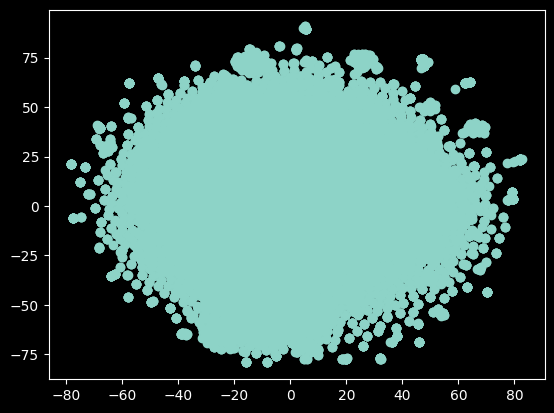

In [9]:
import matplotlib.pyplot as plt
from gensim import matutils
from sklearn.manifold import TSNE

sklearn_vectors = matutils.corpus2csc(bow_corpus).T

model = TSNE(n_components=2, random_state=0, init="random")
transformed = model.fit_transform(sklearn_vectors)
xs = transformed[:, 0]
ys = transformed[:, 1]

plt.scatter(xs, ys)
plt.show()

In [10]:
import pyLDAvis
import pyLDAvis.gensim
from gensim.models.ldamulticore import LdaMulticore

lda_model = LdaMulticore(
    corpus=bow_corpus,
    workers=2,
    id2word=dictionary,
    num_topics=5,
    random_state=100,
    chunksize=50,
    passes=10,
    per_word_topics=True,
)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.224362  0.048564       1        1  34.545844
3      0.160576 -0.072850       2        1  23.476392
4     -0.306315  0.219141       3        1  23.234015
1      0.103177  0.114057       4        1  15.907093
0     -0.181800 -0.308912       5        1   2.836657, topic_info=            Term          Freq         Total Category  logprob  loglift
70         haben   7773.000000   7773.000000  Default  30.0000  30.0000
97    experience   5903.000000   5903.000000  Default  29.0000  29.0000
33      kenntnis   8737.000000   8737.000000  Default  28.0000  28.0000
14          data   6482.000000   6482.000000  Default  27.0000  27.0000
22     erfahrung  10214.000000  10214.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
210       bieten    101.905701    349.299721   Topic5  -5.5082   2.3307
1494  vielfältig     86.703919    189.958790   Topic5  -5.6698   2.7782
2678     täglich     84.611551    229.667383   Topic5  -5.6942   2.5640
79         sowie    112.739911  10006.416353   Topic5  -5.4072  -0.9234
3548      talent     82.844128    211.801529   Topic5  -5.7153   2.6239

[314 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
117       1  0.817873    abgeschlossen
117       2  0.034558    abgeschlossen
117       4  0.147626    abgeschlossen
89        3  0.999287          ability
8862      2  0.251454           abitur
...     ...       ...              ...
7604      5  0.981479         zunächst
1515      1  0.998126  zuverlässigkeit
272       2  0.997211       übernehmen
1140      1  0.209375       überzeugen
1140      2  0.789431       überzeugen

[448 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 2, 1])

In [11]:
def calc_topic_for_doc(doc):
    values = []
    tuples = lda_model.get_document_topics(doc)
    for tuple in tuples:
        values.append(tuple[1])
    max_prob = max(values)
    topic = tuples[values.index(max_prob)][0]
    return topic + 1

In [12]:
bow_topic_list = []
for doc in bow_corpus:
    bow_topic_list.append(calc_topic_for_doc(doc))

df_bow = pd.DataFrame(
    {"topics": bow_topic_list, "Job_Kategorie": jobs["Job Kategorie"]}, index=jobs.index
)

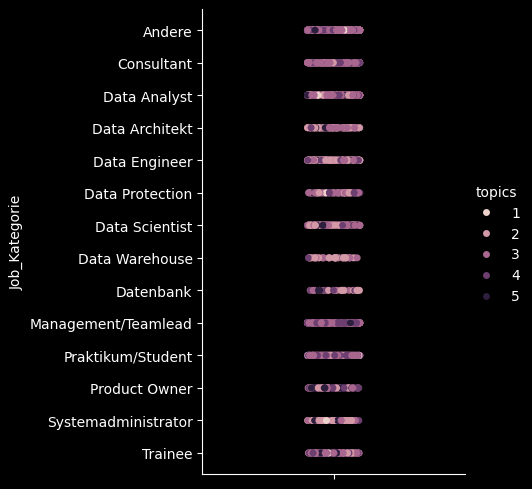

In [13]:
import seaborn as sns

sns.catplot(data=df_bow, hue="topics", y="Job_Kategorie")

# TF-IDF

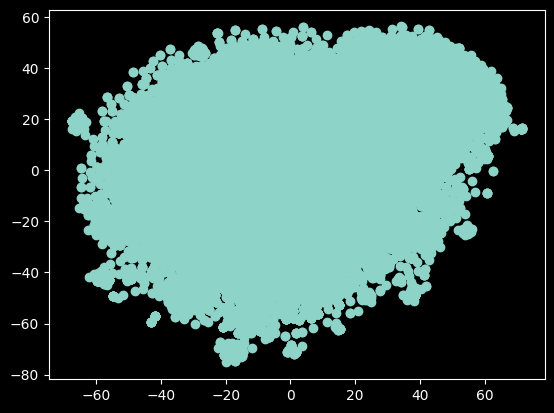

In [14]:
sklearn_vectors = matutils.corpus2csc(tfidf_corpus).T

model = TSNE(n_components=2, random_state=0, init="random")
transformed = model.fit_transform(sklearn_vectors)
xs = transformed[:, 0]
ys = transformed[:, 1]

plt.scatter(xs, ys)
plt.show()

In [15]:
lda_model = LdaMulticore(
    corpus=tfidf_corpus,
    workers=2,
    id2word=dictionary,
    num_topics=3,
    random_state=100,
    chunksize=50,
    passes=10,
    per_word_topics=True,
)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, tfidf_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.185179 -0.007499       1        1  70.877623
0     -0.109025 -0.059621       2        1  22.428563
1     -0.076154  0.067120       3        1   6.693814, topic_info=                        Term        Freq       Total Category  logprob  \
97                experience  101.000000  101.000000  Default  30.0000   
108                   skills   74.000000   74.000000  Default  29.0000   
70                     haben  272.000000  272.000000  Default  28.0000   
14                      data  138.000000  138.000000  Default  27.0000   
101                 knowledg   47.000000   47.000000  Default  26.0000   
...                      ...         ...         ...      ...      ...   
19919  vergleichbarerfahrung    1.421150    2.333515   Topic3  -8.3819   
6706                   extra    1.812314    3.812277   Topic3  -8.1388   
5781            arbeitsplatz    1.955930    8.217104   Topic3  -8.0625   
25859      persönlichkeitgut    1.444072    2.675537   Topic3  -8.3659   
7547               teilnahme    1.389902    6.865323   Topic3  -8.4042   

       loglift  
97     30.0000  
108    29.0000  
70     28.0000  
14     27.0000  
101    26.0000  
...        ...  
19919   2.2081  
6706    1.9604  
5781    1.2686  
25859   2.0873  
7547    1.1067  

[150 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
117        1  0.997763  abgeschlossen
89         2  0.985384        ability
7302       1  0.411549         ablauf
7302       3  0.823098         ablauf
23573      3  0.479395   affinitätgut
...      ...       ...            ...
635        2  0.988381        working
154        1  0.995509           wort
1205       2  0.996407        written
1175       2  0.980143           year
63         1  0.999195              z

[142 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [16]:
tfidf_topic_list = []
for doc in tfidf_corpus:
    tfidf_topic_list.append(calc_topic_for_doc(doc))

df_tfidf = pd.DataFrame(
    {"topics": tfidf_topic_list, "Job_Kategorie": jobs["Job Kategorie"]},
    index=jobs.index,
)

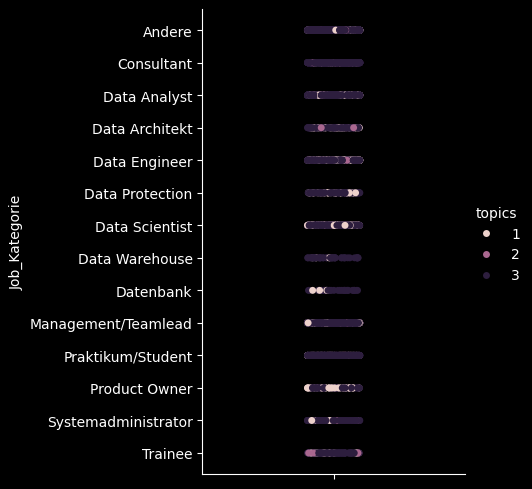

In [17]:
sns.catplot(data=df_tfidf, hue="topics", y="Job_Kategorie")